In [1]:
"""2025ML_HW2_sample.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1YT4zCSCfrPnry01kM-xI2brJYQUuE6rz

# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data
"""

!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

"""#### Import packages"""

import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm


Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=61f86176-d818-4012-8ce4-28adbfa69080
To: /content/HW2.zip
100% 52.1M/52.1M [00:01<00:00, 42.8MB/s]


In [2]:
"""#### Hyperparameters and setting"""
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 128,
    n_epoch = 50,
    lr = 1e-3,
    weight_decay = 1e-5,
    ckpt_path = 'model.pth',
)

TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

In [3]:
"""#### Dataset and Dataloader"""

class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

# TODO: define your augmentation for training and evaluation
# 1. 定義一個用於計算統計量的基礎轉換
calc_tfm = T.Compose([
    T.Resize((64, 64)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(), # 這一層會將像素值轉換到 [0.0, 1.0] 區間
])

# 2. 建立一個臨時的 Dataset 和 DataLoader (使用整個訓練集)
# 注意：這裡我們使用完整的 train_dataset，不進行 train/valid 分割
full_train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=calc_tfm)

# 設置一個足夠大的 BATCH_SIZE 以加快計算
calc_loader = DataLoader(full_train_dataset, batch_size=256, shuffle=False)

def calculate_mean_std(loader):
    """計算資料集的 Mean 和 Std。"""

    channels = 1 # 灰度圖
    # 初始化統計量
    sum_val = torch.zeros(channels)
    sum_sq_val = torch.zeros(channels)
    total_pixels = 0

    # 遍歷所有批次
    for images, _ in tqdm(loader, desc="Calculating Mean and Std"):
        # images 的形狀: (BATCH, 1, H, W)

        # 將圖片展平，只保留通道維度
        # 例：(256, 1, 48, 48) -> (256 * 48 * 48, 1)
        pixels = images.view(-1, channels)

        # 累積總和
        sum_val += pixels.sum(dim=0).cpu() # dim=0 在展平後的軸上求和

        # 累積平方總和
        sum_sq_val += (pixels ** 2).sum(dim=0).cpu()

        # 累積像素總數量 (H * W * BATCH_SIZE)
        total_pixels += pixels.size(0)

    # 最終計算
    mean = sum_val / total_pixels

    # 方差 (Variance) = (平方總和 / 總像素數) - (平均值)^2
    variance = (sum_sq_val / total_pixels) - (mean ** 2)

    # 標準差 (Std) = sqrt(方差)
    std = torch.sqrt(variance)

    # 因為是單通道，結果會是 [mean_val] 和 [std_val]，取第一個元素即可
    return mean.item(), std.item()

# 執行計算
dataset_mean, dataset_std = calculate_mean_std(calc_loader)

print(f"Dataset Mean (灰度): {dataset_mean:.4f}")
print(f"Dataset Std (灰度): {dataset_std:.4f}")

MEAN = [dataset_mean]
STD = [dataset_std]

train_tfm = T.Compose([
    # 灰度圖片通常是 48x48，但原始讀取是 3 通道灰度圖，需要處理
    T.Grayscale(num_output_channels=1),
    T.Resize((64, 64)),
    # 1. 資料增強
    T.RandomHorizontalFlip(p=0.5),  # 左右翻轉
    T.RandomRotation(15),           # 隨機旋轉
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)), # 仿射變換

    # # 2. 轉換與標準化
    T.ToTensor(),
    T.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3)),

    # 對單通道灰度圖進行標準化 (請使用您資料集實際的 Mean/Std，這裡使用常見值)
    T.Normalize(mean=MEAN, std=STD),
])

eval_tfm = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])

# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

Calculating Mean and Std: 100%|██████████| 113/113 [00:11<00:00,  9.84it/s]

Dataset Mean (灰度): 0.5082
Dataset Std (灰度): 0.2644


In [4]:
"""#### Model"""

# TODO: define your CNN model

class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.relu = nn.LeakyReLU(0.1)

        # === 卷積區塊 (與您的原始程式碼相同) ===
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), self.relu,
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2) # 尺寸: 64x64 -> 32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), self.relu,
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2) # 尺寸: 32x32 -> 16x16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), self.relu,
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2) # 尺寸: 16x16 -> 8x8
        )

        # 傳統全展平: 256 * 8 * 8 = 16384
        INPUT_SIZE = 256 * 8 * 8  # 16384

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),
            # ⭐ FC 層輸入尺寸設為 16384
            nn.Linear(INPUT_SIZE, 256),
            nn.BatchNorm1d(256),
            self.relu,
            nn.Dropout(0.3),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # ⭐ 傳統展平操作，保留所有空間資訊
        x = x.view(x.size(0), -1) # 尺寸: BATCH x 16384

        x = self.fc_layers(x)
        return x

In [5]:
"""#### training loop"""

def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
        scheduler.step(valid_acc)
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 181/181 [00:38<00:00,  4.71it/s]


Epoch: 1/50, train loss: 1.6978, train acc: 0.3223
Epoch: 1/50, valid loss: 1.6375, valid acc: 0.3677
== best valid acc: 0.3677 ==


100%|██████████| 181/181 [00:37<00:00,  4.88it/s]


Epoch: 2/50, train loss: 1.4448, train acc: 0.4421
Epoch: 2/50, valid loss: 1.4744, valid acc: 0.4411
== best valid acc: 0.4411 ==


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 3/50, train loss: 1.3582, train acc: 0.4737
Epoch: 3/50, valid loss: 1.3870, valid acc: 0.4565
== best valid acc: 0.4565 ==


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 4/50, train loss: 1.2996, train acc: 0.5027
Epoch: 4/50, valid loss: 1.2809, valid acc: 0.5040
== best valid acc: 0.5040 ==


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 5/50, train loss: 1.2556, train acc: 0.5204
Epoch: 5/50, valid loss: 1.2355, valid acc: 0.5251
== best valid acc: 0.5251 ==


100%|██████████| 181/181 [00:37<00:00,  4.87it/s]


Epoch: 6/50, train loss: 1.2345, train acc: 0.5260
Epoch: 6/50, valid loss: 1.2021, valid acc: 0.5446
== best valid acc: 0.5446 ==


100%|██████████| 181/181 [00:37<00:00,  4.85it/s]


Epoch: 7/50, train loss: 1.2109, train acc: 0.5388
Epoch: 7/50, valid loss: 1.2452, valid acc: 0.5224


100%|██████████| 181/181 [00:37<00:00,  4.89it/s]


Epoch: 8/50, train loss: 1.1743, train acc: 0.5518
Epoch: 8/50, valid loss: 1.2042, valid acc: 0.5419


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 9/50, train loss: 1.1647, train acc: 0.5551
Epoch: 9/50, valid loss: 1.1847, valid acc: 0.5505
== best valid acc: 0.5505 ==


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 10/50, train loss: 1.1412, train acc: 0.5642
Epoch: 10/50, valid loss: 1.1672, valid acc: 0.5527
== best valid acc: 0.5527 ==


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 11/50, train loss: 1.1253, train acc: 0.5746
Epoch: 11/50, valid loss: 1.1758, valid acc: 0.5480


100%|██████████| 181/181 [00:37<00:00,  4.88it/s]


Epoch: 12/50, train loss: 1.1139, train acc: 0.5788
Epoch: 12/50, valid loss: 1.1649, valid acc: 0.5490


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 13/50, train loss: 1.1087, train acc: 0.5758
Epoch: 13/50, valid loss: 1.1302, valid acc: 0.5779
== best valid acc: 0.5779 ==


100%|██████████| 181/181 [00:37<00:00,  4.89it/s]


Epoch: 14/50, train loss: 1.0927, train acc: 0.5851
Epoch: 14/50, valid loss: 1.1133, valid acc: 0.5799
== best valid acc: 0.5799 ==


100%|██████████| 181/181 [00:37<00:00,  4.87it/s]


Epoch: 15/50, train loss: 1.0826, train acc: 0.5873
Epoch: 15/50, valid loss: 1.0891, valid acc: 0.5907
== best valid acc: 0.5907 ==


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 16/50, train loss: 1.0704, train acc: 0.5932
Epoch: 16/50, valid loss: 1.1100, valid acc: 0.5834


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 17/50, train loss: 1.0544, train acc: 0.6016
Epoch: 17/50, valid loss: 1.0863, valid acc: 0.5851


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 18/50, train loss: 1.0547, train acc: 0.5960
Epoch: 18/50, valid loss: 1.1218, valid acc: 0.5676


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 19/50, train loss: 1.0460, train acc: 0.6050
Epoch: 19/50, valid loss: 1.0974, valid acc: 0.5852


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 20/50, train loss: 1.0339, train acc: 0.6068
Epoch: 20/50, valid loss: 1.0684, valid acc: 0.5989
== best valid acc: 0.5989 ==


100%|██████████| 181/181 [00:37<00:00,  4.88it/s]


Epoch: 21/50, train loss: 1.0276, train acc: 0.6143
Epoch: 21/50, valid loss: 1.0707, valid acc: 0.5977


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 22/50, train loss: 1.0235, train acc: 0.6120
Epoch: 22/50, valid loss: 1.1015, valid acc: 0.5861


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 23/50, train loss: 1.0093, train acc: 0.6173
Epoch: 23/50, valid loss: 1.0883, valid acc: 0.5869


100%|██████████| 181/181 [00:36<00:00,  4.92it/s]


Epoch: 24/50, train loss: 1.0028, train acc: 0.6221
Epoch: 24/50, valid loss: 1.0859, valid acc: 0.5909


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 25/50, train loss: 0.9961, train acc: 0.6200
Epoch: 25/50, valid loss: 1.0582, valid acc: 0.6061
== best valid acc: 0.6061 ==


100%|██████████| 181/181 [00:36<00:00,  4.92it/s]


Epoch: 26/50, train loss: 0.9908, train acc: 0.6275
Epoch: 26/50, valid loss: 1.0518, valid acc: 0.6088
== best valid acc: 0.6088 ==


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 27/50, train loss: 0.9779, train acc: 0.6287
Epoch: 27/50, valid loss: 1.0502, valid acc: 0.6128
== best valid acc: 0.6128 ==


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 28/50, train loss: 0.9692, train acc: 0.6367
Epoch: 28/50, valid loss: 1.0366, valid acc: 0.6140
== best valid acc: 0.6140 ==


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 29/50, train loss: 0.9651, train acc: 0.6356
Epoch: 29/50, valid loss: 1.0368, valid acc: 0.6111


100%|██████████| 181/181 [00:36<00:00,  4.92it/s]


Epoch: 30/50, train loss: 0.9612, train acc: 0.6371
Epoch: 30/50, valid loss: 1.0315, valid acc: 0.6185
== best valid acc: 0.6185 ==


100%|██████████| 181/181 [00:36<00:00,  4.89it/s]


Epoch: 31/50, train loss: 0.9504, train acc: 0.6389
Epoch: 31/50, valid loss: 1.0302, valid acc: 0.6120


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 32/50, train loss: 0.9465, train acc: 0.6435
Epoch: 32/50, valid loss: 1.0228, valid acc: 0.6139


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 33/50, train loss: 0.9398, train acc: 0.6445
Epoch: 33/50, valid loss: 1.0471, valid acc: 0.6126


100%|██████████| 181/181 [00:36<00:00,  4.92it/s]


Epoch: 34/50, train loss: 0.9353, train acc: 0.6463
Epoch: 34/50, valid loss: 1.0220, valid acc: 0.6176


100%|██████████| 181/181 [00:36<00:00,  4.93it/s]


Epoch: 35/50, train loss: 0.9278, train acc: 0.6492
Epoch: 35/50, valid loss: 1.0223, valid acc: 0.6278
== best valid acc: 0.6278 ==


100%|██████████| 181/181 [00:37<00:00,  4.89it/s]


Epoch: 36/50, train loss: 0.9278, train acc: 0.6525
Epoch: 36/50, valid loss: 1.0324, valid acc: 0.6175


100%|██████████| 181/181 [00:37<00:00,  4.89it/s]


Epoch: 37/50, train loss: 0.9185, train acc: 0.6534
Epoch: 37/50, valid loss: 1.0302, valid acc: 0.6158


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 38/50, train loss: 0.9126, train acc: 0.6569
Epoch: 38/50, valid loss: 1.0280, valid acc: 0.6192


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 39/50, train loss: 0.9127, train acc: 0.6542
Epoch: 39/50, valid loss: 1.0085, valid acc: 0.6199


100%|██████████| 181/181 [00:36<00:00,  4.90it/s]


Epoch: 40/50, train loss: 0.8959, train acc: 0.6628
Epoch: 40/50, valid loss: 1.0138, valid acc: 0.6228


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 41/50, train loss: 0.8997, train acc: 0.6631
Epoch: 41/50, valid loss: 1.0171, valid acc: 0.6270


100%|██████████| 181/181 [00:36<00:00,  4.94it/s]


Epoch: 42/50, train loss: 0.8609, train acc: 0.6779
Epoch: 42/50, valid loss: 0.9997, valid acc: 0.6261


100%|██████████| 181/181 [00:36<00:00,  4.92it/s]


Epoch: 43/50, train loss: 0.8456, train acc: 0.6796
Epoch: 43/50, valid loss: 0.9920, valid acc: 0.6378
== best valid acc: 0.6378 ==


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 44/50, train loss: 0.8341, train acc: 0.6871
Epoch: 44/50, valid loss: 0.9843, valid acc: 0.6349


100%|██████████| 181/181 [00:36<00:00,  4.93it/s]


Epoch: 45/50, train loss: 0.8358, train acc: 0.6852
Epoch: 45/50, valid loss: 0.9812, valid acc: 0.6431
== best valid acc: 0.6431 ==


100%|██████████| 181/181 [00:36<00:00,  4.91it/s]


Epoch: 46/50, train loss: 0.8254, train acc: 0.6906
Epoch: 46/50, valid loss: 0.9873, valid acc: 0.6375


100%|██████████| 181/181 [00:36<00:00,  4.92it/s]


Epoch: 47/50, train loss: 0.8250, train acc: 0.6901
Epoch: 47/50, valid loss: 1.0033, valid acc: 0.6377


100%|██████████| 181/181 [00:36<00:00,  4.92it/s]


Epoch: 48/50, train loss: 0.8179, train acc: 0.6910
Epoch: 48/50, valid loss: 0.9868, valid acc: 0.6466
== best valid acc: 0.6466 ==


100%|██████████| 181/181 [00:36<00:00,  4.93it/s]


Epoch: 49/50, train loss: 0.8115, train acc: 0.6942
Epoch: 49/50, valid loss: 0.9906, valid acc: 0.6387


100%|██████████| 181/181 [00:36<00:00,  4.93it/s]


Epoch: 50/50, train loss: 0.8058, train acc: 0.6980
Epoch: 50/50, valid loss: 0.9790, valid acc: 0.6460


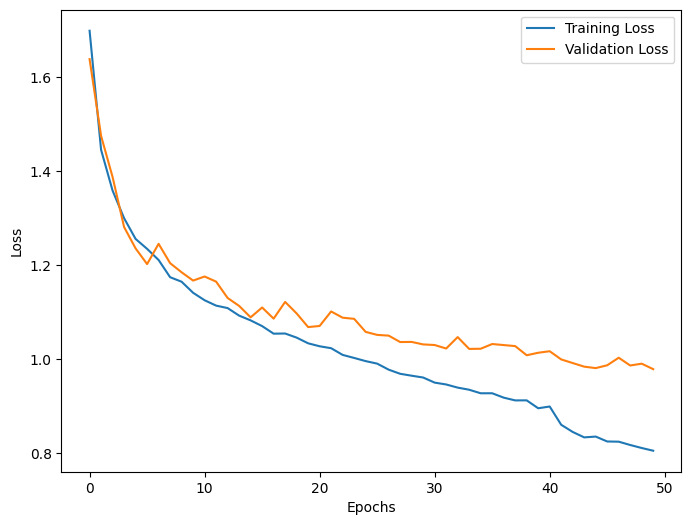

100%|██████████| 46/46 [00:06<00:00,  7.46it/s]


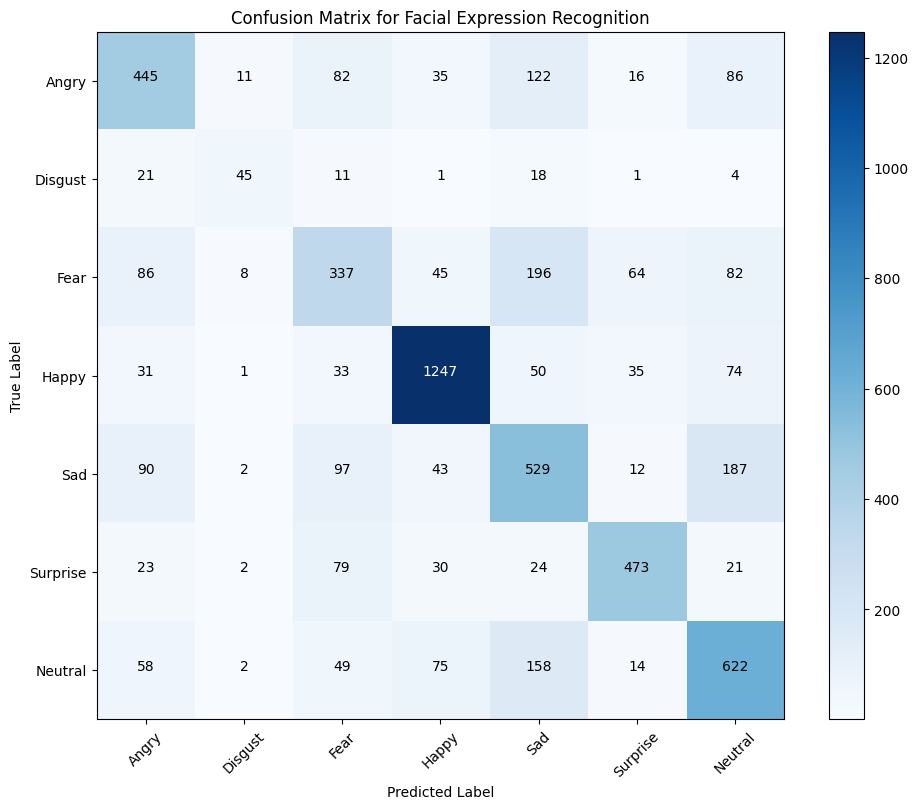

In [6]:
"""### Training"""

model = FaceExpressionNet()
train(model, train_loader, valid_loader, config)

def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    # 將列表轉換為 NumPy 陣列
    y_true = np.array(labels)
    y_pred = np.array(predictions)

    # 2. 手動計算混淆矩陣 (代替 sklearn.metrics.confusion_matrix)
    num_classes = 7 # 您的情緒類別數量
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        # cm[i, j] 是真實標籤 i 被預測為 j 的次數
        cm[true_label, pred_label] += 1

    # 假設情緒類別 (0-6) 對應的標籤名稱
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # 3. 繪製混淆矩陣
    plt.figure(figsize=(10, 8))

    # 使用 imshow 繪製顏色熱力圖
    # cmap=plt.cm.Blues 是 Matplotlib 內建的藍色色階
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Facial Expression Recognition')
    plt.colorbar() # 添加顏色條

    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, emotion_labels, rotation=45) # 設置 X 軸標籤
    plt.yticks(tick_marks, emotion_labels)             # 設置 Y 軸標籤

    # 4. 在每個格子上添加數值標註 (Annotation)
    thresh = cm.max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            # 根據背景顏色，調整文字顏色 (深色背景用白色字，淺色背景用黑色字)
            color = "white" if cm[i, j] > thresh else "black"

            # 使用 plt.text 函式，將數值放置在格子中央
            plt.text(j, i, format(cm[i, j], 'd'), # 'd' 表示整數格式
                     horizontalalignment="center",
                     color=color)

    plt.tight_layout() # 自動調整佈局，避免標籤重疊
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 確保在訓練後呼叫
model.load_state_dict(torch.load(config.ckpt_path)) # 確保載入最佳模型
draw_confusion_matrix(model, valid_loader)

In [ ]:
"""### Testing"""

def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)